In [ ]:
# Worked on Contagio Dataset

# Final Version with split : 80 10 10

Epoch [1/100], Train Loss: 0.0014, Train Acc: 0.9714, Val Loss: 0.0007, Val Acc: 0.9875
Epoch [2/100], Train Loss: 0.0005, Train Acc: 0.9896, Val Loss: 0.0005, Val Acc: 0.9913
Epoch [3/100], Train Loss: 0.0004, Train Acc: 0.9926, Val Loss: 0.0004, Val Acc: 0.9925
Epoch [4/100], Train Loss: 0.0003, Train Acc: 0.9942, Val Loss: 0.0004, Val Acc: 0.9929
Epoch [5/100], Train Loss: 0.0003, Train Acc: 0.9951, Val Loss: 0.0003, Val Acc: 0.9940
Epoch [6/100], Train Loss: 0.0002, Train Acc: 0.9958, Val Loss: 0.0003, Val Acc: 0.9931
Epoch [7/100], Train Loss: 0.0002, Train Acc: 0.9957, Val Loss: 0.0004, Val Acc: 0.9935
Epoch [8/100], Train Loss: 0.0002, Train Acc: 0.9964, Val Loss: 0.0003, Val Acc: 0.9941
Epoch [9/100], Train Loss: 0.0002, Train Acc: 0.9967, Val Loss: 0.0004, Val Acc: 0.9930
Epoch [10/100], Train Loss: 0.0002, Train Acc: 0.9968, Val Loss: 0.0003, Val Acc: 0.9940
Epoch [11/100], Train Loss: 0.0002, Train Acc: 0.9970, Val Loss: 0.0003, Val Acc: 0.9945
Epoch [12/100], Train Loss: 0.

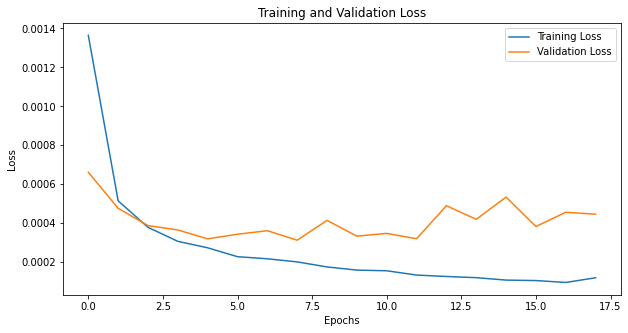

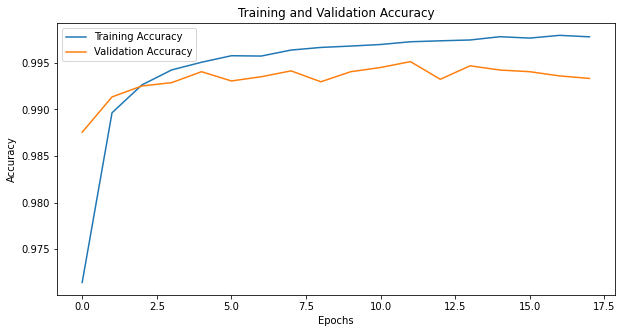

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import math

# Load the full dataset - Contagio Dataset
data = pd.read_csv('/home/sharmila/MyCodes/ReWorkPDFmalware/PDFdatasets/dataset.csv')  # Replace with your actual dataset path

# EDA: Display basic information
# print("Dataset Overview:")
# print(data.info())

# Summary statistics
# print("\nSummary Statistics:")
# print(data.describe())

# Check for missing values
# print("\nMissing Values:")
# print(data.isnull().sum())

# Correlation heatmap for numerical features only
numeric_data = data.select_dtypes(include=[np.number])
# plt.figure(figsize=(15, 10))
# sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
# plt.title('Feature Correlation Matrix')
# plt.show()

# Preprocessing
target = 'class'  # Define your target variable
X = data.drop(columns=[target, 'filename'])  # Drop target and any non-feature columns
y = data[target]

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Preprocess the features
X_preprocessed = preprocessor.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into 80-10-10 (train, validation, test)
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=3, spline_order=3, scale_noise=0.05, scale_base=1.0, 
                 scale_spline=0.5, enable_standalone_scale_spline=True, base_activation=None, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)
        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))
        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation() if base_activation is not None else nn.GELU()
        self.grid_eps = grid_eps
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * 
                                          self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + \
                    ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy

class KAN(nn.Module):
    def __init__(self, layers_hidden, grid_size=3, spline_order=3, scale_noise=0.05, scale_base=1.0, scale_spline=0.5, 
                 base_activation=nn.GELU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_features, out_features, grid_size, spline_order, scale_noise, scale_base, 
                                         scale_spline, True, base_activation, grid_eps, grid_range))

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=0.01, regularize_entropy=0.01):
        return sum(layer.regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers)

def train_model(model, X_train, y_train, X_val, y_val, num_epochs=100, batch_size=64):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        train_losses.append(train_loss / len(X_train))
        train_accuracies.append(train_correct / len(X_train))

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                batch_X = X_val[i:i + batch_size]
                batch_y = y_val[i:i + batch_size]
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        
        val_losses.append(val_loss / len(X_val))
        val_accuracies.append(val_correct / len(X_val))

        # Check for best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # Reset the counter since we have improved
        else:
            counter += 1
        
        # Reduce learning rate if no improvement in validation loss
        scheduler.step(val_correct / len(X_val))
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping on epoch {epoch + 1}")
            break
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(X_train):.4f}, Train Acc: {train_correct / len(X_train):.4f}, Val Loss: {val_loss / len(X_val):.4f}, Val Acc: {val_correct / len(X_val):.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_model(model, X_test, y_test):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for i in range(0, len(X_test), 64):  # Using the same batch size
            batch_X = X_test[i:i + 64]
            batch_y = y_test[i:i + 64]
            outputs = model(batch_X)
            test_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
    
    test_accuracy = test_correct / len(X_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Initialize and train the model
layers_hidden = [X_train_tensor.shape[1], 128, 64, 32, 16, len(label_encoder.classes_)]  # Example hidden layer sizes
model = KAN(layers_hidden, grid_size=3, spline_order=3)

# Move model to device if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=100)

# Evaluate the model on the test set
evaluate_model(model, X_test_tensor, y_test_tensor)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

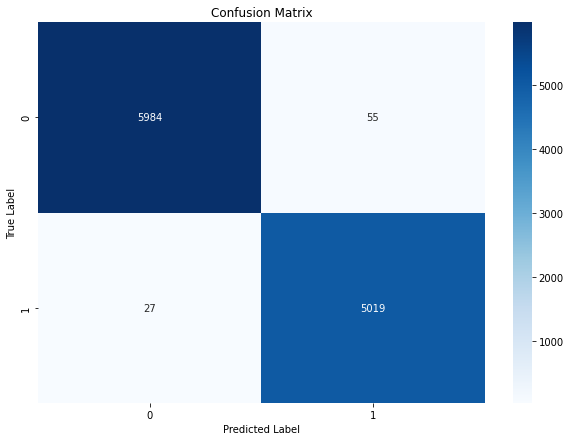

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the model
model.eval()
y_pred = []
with torch.no_grad():
    for i in range(0, len(X_test_tensor), 64):  # Using the same batch size
        batch_X = X_test_tensor[i:i + 64]
        outputs = model(batch_X)
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Convert predictions and true labels to numpy arrays
y_pred = np.array(y_pred)
y_test_np = y_test_tensor.cpu().numpy()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Final Version : 70 15 15¶

Epoch [1/100], Train Loss: 0.0015, Train Acc: 0.9692, Val Loss: 0.0007, Val Acc: 0.9860
Epoch [2/100], Train Loss: 0.0005, Train Acc: 0.9890, Val Loss: 0.0005, Val Acc: 0.9893
Epoch [3/100], Train Loss: 0.0004, Train Acc: 0.9926, Val Loss: 0.0005, Val Acc: 0.9910
Epoch [4/100], Train Loss: 0.0003, Train Acc: 0.9944, Val Loss: 0.0004, Val Acc: 0.9919
Epoch [5/100], Train Loss: 0.0003, Train Acc: 0.9949, Val Loss: 0.0004, Val Acc: 0.9918
Epoch [6/100], Train Loss: 0.0002, Train Acc: 0.9956, Val Loss: 0.0004, Val Acc: 0.9921
Epoch [7/100], Train Loss: 0.0002, Train Acc: 0.9964, Val Loss: 0.0005, Val Acc: 0.9916
Epoch [8/100], Train Loss: 0.0002, Train Acc: 0.9965, Val Loss: 0.0004, Val Acc: 0.9933
Epoch [9/100], Train Loss: 0.0002, Train Acc: 0.9965, Val Loss: 0.0005, Val Acc: 0.9922
Epoch [10/100], Train Loss: 0.0002, Train Acc: 0.9968, Val Loss: 0.0004, Val Acc: 0.9940
Epoch [11/100], Train Loss: 0.0001, Train Acc: 0.9973, Val Loss: 0.0003, Val Acc: 0.9944
Epoch [12/100], Train Loss: 0.

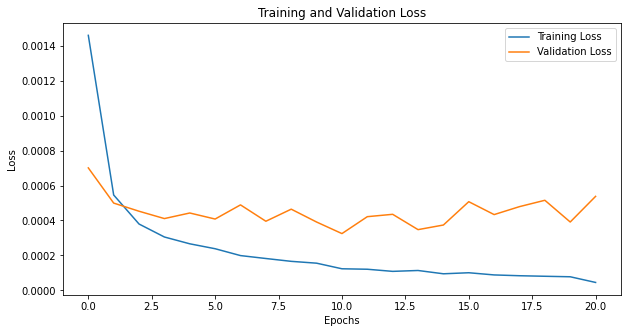

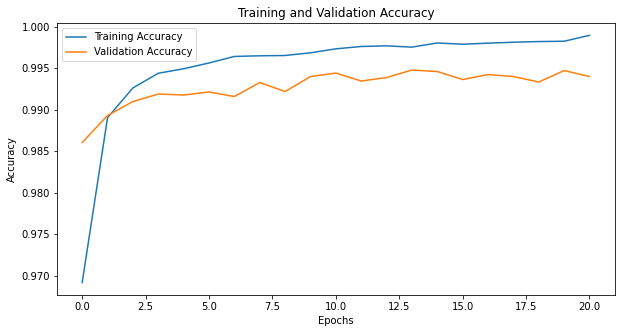

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import math

# Load the full dataset - Contagio Dataset
data = pd.read_csv('/home/sharmila/MyCodes/ReWorkPDFmalware/PDFdatasets/dataset.csv')  # Replace with your actual dataset path

# EDA: Display basic information
# print("Dataset Overview:")
# print(data.info())

# Summary statistics
# print("\nSummary Statistics:")
# print(data.describe())

# Check for missing values
# print("\nMissing Values:")
# print(data.isnull().sum())

# Correlation heatmap for numerical features only
numeric_data = data.select_dtypes(include=[np.number])
# plt.figure(figsize=(15, 10))
#sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
# plt.title('Feature Correlation Matrix')
# plt.show()

# Preprocessing
target = 'class'  # Define your target variable
X = data.drop(columns=[target, 'filename'])  # Drop target and any non-feature columns
y = data[target]

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Preprocess the features
X_preprocessed = preprocessor.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y_encoded, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=3, spline_order=3, scale_noise=0.05, scale_base=1.0, 
                 scale_spline=0.5, enable_standalone_scale_spline=True, base_activation=None, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)
        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))
        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation() if base_activation is not None else nn.GELU()
        self.grid_eps = grid_eps
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * 
                                          self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + \
                    ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy

class KAN(nn.Module):
    def __init__(self, layers_hidden, grid_size=3, spline_order=3, scale_noise=0.05, scale_base=1.0, scale_spline=0.5, 
                 base_activation=nn.GELU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_features, out_features, grid_size, spline_order, scale_noise, scale_base, 
                                         scale_spline, True, base_activation, grid_eps, grid_range))

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=0.01, regularize_entropy=0.01):
        return sum(layer.regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers)

def train_model(model, X_train, y_train, X_val, y_val, num_epochs=100, batch_size=64):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        train_losses.append(train_loss / len(X_train))
        train_accuracies.append(train_correct / len(X_train))

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                batch_X = X_val[i:i + batch_size]
                batch_y = y_val[i:i + batch_size]
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        
        val_losses.append(val_loss / len(X_val))
        val_accuracies.append(val_correct / len(X_val))

        # Check for best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # Reset the counter since we have improved
        else:
            counter += 1
        
        # Reduce learning rate if no improvement in validation loss
        scheduler.step(val_correct / len(X_val))
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping on epoch {epoch + 1}")
            break
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(X_train):.4f}, Train Acc: {train_correct / len(X_train):.4f}, Val Loss: {val_loss / len(X_val):.4f}, Val Acc: {val_correct / len(X_val):.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_model(model, X_test, y_test):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for i in range(0, len(X_test), 64):  # Using the same batch size
            batch_X = X_test[i:i + 64]
            batch_y = y_test[i:i + 64]
            outputs = model(batch_X)
            test_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
    
    test_accuracy = test_correct / len(X_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Initialize and train the model
layers_hidden = [X_train_tensor.shape[1], 128, 64, 32, 16, len(label_encoder.classes_)]  # Example hidden layer sizes
model = KAN(layers_hidden, grid_size=3, spline_order=3)

# Move model to device if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=100)

# Evaluate the model on the test set
evaluate_model(model, X_test_tensor, y_test_tensor)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

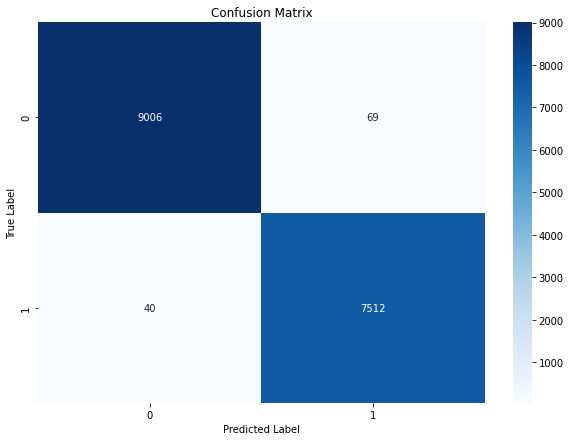

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the model
model.eval()
y_pred = []
with torch.no_grad():
    for i in range(0, len(X_test_tensor), 64):  # Using the same batch size
        batch_X = X_test_tensor[i:i + 64]
        outputs = model(batch_X)
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Convert predictions and true labels to numpy arrays
y_pred = np.array(y_pred)
y_test_np = y_test_tensor.cpu().numpy()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Final Version : 60 20 20

Epoch [1/100], Train Loss: 0.0016, Train Acc: 0.9673, Val Loss: 0.0008, Val Acc: 0.9857
Epoch [2/100], Train Loss: 0.0006, Train Acc: 0.9884, Val Loss: 0.0005, Val Acc: 0.9902
Epoch [3/100], Train Loss: 0.0004, Train Acc: 0.9914, Val Loss: 0.0004, Val Acc: 0.9915
Epoch [4/100], Train Loss: 0.0003, Train Acc: 0.9936, Val Loss: 0.0004, Val Acc: 0.9920
Epoch [5/100], Train Loss: 0.0003, Train Acc: 0.9944, Val Loss: 0.0004, Val Acc: 0.9926
Epoch [6/100], Train Loss: 0.0002, Train Acc: 0.9956, Val Loss: 0.0005, Val Acc: 0.9921
Epoch [7/100], Train Loss: 0.0002, Train Acc: 0.9958, Val Loss: 0.0004, Val Acc: 0.9933
Epoch [8/100], Train Loss: 0.0002, Train Acc: 0.9963, Val Loss: 0.0005, Val Acc: 0.9922
Epoch [9/100], Train Loss: 0.0002, Train Acc: 0.9966, Val Loss: 0.0004, Val Acc: 0.9937
Epoch [10/100], Train Loss: 0.0002, Train Acc: 0.9966, Val Loss: 0.0005, Val Acc: 0.9934
Epoch [11/100], Train Loss: 0.0001, Train Acc: 0.9969, Val Loss: 0.0005, Val Acc: 0.9933
Epoch [12/100], Train Loss: 0.

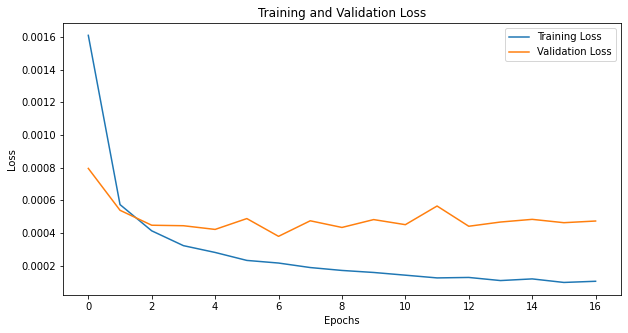

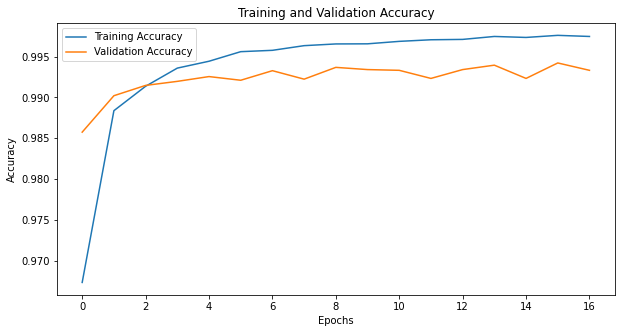

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import math

# Load the full dataset - Contagio Dataset
data = pd.read_csv('/home/sharmila/MyCodes/ReWorkPDFmalware/PDFdatasets/dataset.csv')  # Replace with your actual dataset path


# EDA: Display basic information
# print("Dataset Overview:")
# print(data.info())

# Summary statistics
# print("\nSummary Statistics:")
# print(data.describe())

# Check for missing values
# print("\nMissing Values:")
# print(data.isnull().sum())

# Correlation heatmap for numerical features only
numeric_data = data.select_dtypes(include=[np.number])
# plt.figure(figsize=(15, 10))
#sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
# plt.title('Feature Correlation Matrix')
# plt.show()

# Preprocessing
target = 'class'  # Define your target variable
X = data.drop(columns=[target, 'filename'])  # Drop target and any non-feature columns
y = data[target]

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Preprocess the features
X_preprocessed = preprocessor.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y_encoded, test_size=0.40, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=3, spline_order=3, scale_noise=0.05, scale_base=1.0, 
                 scale_spline=0.5, enable_standalone_scale_spline=True, base_activation=None, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)
        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))
        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation() if base_activation is not None else nn.GELU()
        self.grid_eps = grid_eps
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * 
                                          self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + \
                    ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy

class KAN(nn.Module):
    def __init__(self, layers_hidden, grid_size=3, spline_order=3, scale_noise=0.05, scale_base=1.0, scale_spline=0.5, 
                 base_activation=nn.GELU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_features, out_features, grid_size, spline_order, scale_noise, scale_base, 
                                         scale_spline, True, base_activation, grid_eps, grid_range))

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=0.01, regularize_entropy=0.01):
        return sum(layer.regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers)

def train_model(model, X_train, y_train, X_val, y_val, num_epochs=100, batch_size=64):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        train_losses.append(train_loss / len(X_train))
        train_accuracies.append(train_correct / len(X_train))

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                batch_X = X_val[i:i + batch_size]
                batch_y = y_val[i:i + batch_size]
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        
        val_losses.append(val_loss / len(X_val))
        val_accuracies.append(val_correct / len(X_val))

        # Check for best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # Reset the counter since we have improved
        else:
            counter += 1
        
        # Reduce learning rate if no improvement in validation loss
        scheduler.step(val_correct / len(X_val))
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping on epoch {epoch + 1}")
            break
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(X_train):.4f}, Train Acc: {train_correct / len(X_train):.4f}, Val Loss: {val_loss / len(X_val):.4f}, Val Acc: {val_correct / len(X_val):.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_model(model, X_test, y_test):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for i in range(0, len(X_test), 64):  # Using the same batch size
            batch_X = X_test[i:i + 64]
            batch_y = y_test[i:i + 64]
            outputs = model(batch_X)
            test_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
    
    test_accuracy = test_correct / len(X_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Initialize and train the model
layers_hidden = [X_train_tensor.shape[1], 128, 64, 32, 16, len(label_encoder.classes_)]  # Example hidden layer sizes
model = KAN(layers_hidden, grid_size=3, spline_order=3)

# Move model to device if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=100)

# Evaluate the model on the test set
evaluate_model(model, X_test_tensor, y_test_tensor)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

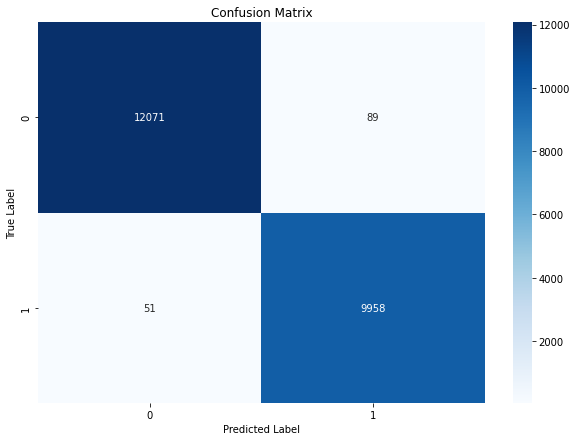

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the model
model.eval()
y_pred = []
with torch.no_grad():
    for i in range(0, len(X_test_tensor), 64):  # Using the same batch size
        batch_X = X_test_tensor[i:i + 64]
        outputs = model(batch_X)
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Convert predictions and true labels to numpy arrays
y_pred = np.array(y_pred)
y_test_np = y_test_tensor.cpu().numpy()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Final Version : 50 25 25

Epoch [1/100], Train Loss: 0.0018, Train Acc: 0.9621, Val Loss: 0.0009, Val Acc: 0.9834
Epoch [2/100], Train Loss: 0.0006, Train Acc: 0.9865, Val Loss: 0.0006, Val Acc: 0.9881
Epoch [3/100], Train Loss: 0.0004, Train Acc: 0.9908, Val Loss: 0.0005, Val Acc: 0.9911
Epoch [4/100], Train Loss: 0.0004, Train Acc: 0.9933, Val Loss: 0.0005, Val Acc: 0.9911
Epoch [5/100], Train Loss: 0.0003, Train Acc: 0.9946, Val Loss: 0.0005, Val Acc: 0.9919
Epoch [6/100], Train Loss: 0.0003, Train Acc: 0.9951, Val Loss: 0.0005, Val Acc: 0.9909
Epoch [7/100], Train Loss: 0.0002, Train Acc: 0.9959, Val Loss: 0.0005, Val Acc: 0.9893
Epoch [8/100], Train Loss: 0.0002, Train Acc: 0.9959, Val Loss: 0.0005, Val Acc: 0.9909
Epoch [9/100], Train Loss: 0.0002, Train Acc: 0.9960, Val Loss: 0.0006, Val Acc: 0.9901
Epoch [10/100], Train Loss: 0.0002, Train Acc: 0.9964, Val Loss: 0.0006, Val Acc: 0.9915
Epoch 00011: reducing learning rate of group 0 to 5.0000e-04.
Epoch [11/100], Train Loss: 0.0002, Train Acc: 0.9967, Va

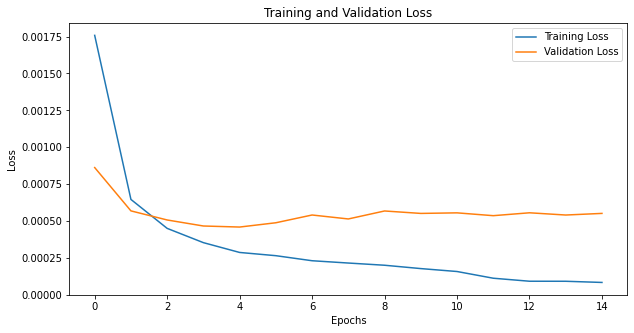

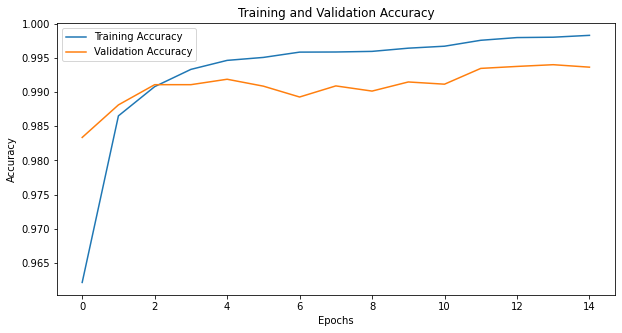

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import math

# Load the full dataset - Contagio Dataset
data = pd.read_csv('/home/sharmila/MyCodes/ReWorkPDFmalware/PDFdatasets/dataset.csv')  # Replace with your actual dataset path


# EDA: Display basic information
# print("Dataset Overview:")
# print(data.info())

# Summary statistics
# print("\nSummary Statistics:")
# print(data.describe())

# Check for missing values
# print("\nMissing Values:")
# print(data.isnull().sum())

# Correlation heatmap for numerical features only
numeric_data = data.select_dtypes(include=[np.number])
# plt.figure(figsize=(15, 10))
#sns.heatmap(numeric_data.corr(), annot=False, cmap='coolwarm')
# plt.title('Feature Correlation Matrix')
# plt.show()

# Preprocessing
target = 'class'  # Define your target variable
X = data.drop(columns=[target, 'filename'])  # Drop target and any non-feature columns
y = data[target]

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ]
)

# Preprocess the features
X_preprocessed = preprocessor.fit_transform(X)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training (50%), validation (25%), and test (25%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_preprocessed, y_encoded, test_size=0.50, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)


# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

class KANLinear(nn.Module):
    def __init__(self, in_features, out_features, grid_size=3, spline_order=3, scale_noise=0.05, scale_base=1.0, 
                 scale_spline=0.5, enable_standalone_scale_spline=True, base_activation=None, grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order
        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (torch.arange(-spline_order, grid_size + spline_order + 1) * h + grid_range[0]).expand(in_features, -1).contiguous()
        self.register_buffer("grid", grid)
        self.base_weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = nn.Parameter(torch.Tensor(out_features, in_features, grid_size + spline_order))
        if enable_standalone_scale_spline:
            self.spline_scaler = nn.Parameter(torch.Tensor(out_features, in_features))
        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation() if base_activation is not None else nn.GELU()
        self.grid_eps = grid_eps
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (torch.rand(self.grid_size + 1, self.in_features, self.out_features) - 1 / 2) * self.scale_noise / self.grid_size
            self.spline_weight.data.copy_((self.scale_spline if not self.enable_standalone_scale_spline else 1.0) * 
                                          self.curve2coeff(self.grid.T[self.spline_order : -self.spline_order], noise))
            if self.enable_standalone_scale_spline:
                nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = ((x - grid[:, : -(k + 1)]) / (grid[:, k:-1] - grid[:, : -(k + 1)]) * bases[:, :, :-1]) + \
                    ((grid[:, k + 1 :] - x) / (grid[:, k + 1 :] - grid[:, 1:(-k)]) * bases[:, :, 1:])
        assert bases.size() == (x.size(0), self.in_features, self.grid_size + self.spline_order)
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)
        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)
        assert result.size() == (self.out_features, self.in_features, self.grid_size + self.spline_order)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (self.spline_scaler.unsqueeze(-1) if self.enable_standalone_scale_spline else 1.0)

    def forward(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(self.b_splines(x).view(x.size(0), -1), self.scaled_spline_weight.view(self.out_features, -1))
        return base_output + spline_output

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return regularize_activation * regularization_loss_activation + regularize_entropy * regularization_loss_entropy

class KAN(nn.Module):
    def __init__(self, layers_hidden, grid_size=3, spline_order=3, scale_noise=0.05, scale_base=1.0, scale_spline=0.5, 
                 base_activation=nn.GELU, grid_eps=0.02, grid_range=[-1, 1]):
        super(KAN, self).__init__()
        self.layers = nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(KANLinear(in_features, out_features, grid_size, spline_order, scale_noise, scale_base, 
                                         scale_spline, True, base_activation, grid_eps, grid_range))

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=0.01, regularize_entropy=0.01):
        return sum(layer.regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers)

def train_model(model, X_train, y_train, X_val, y_val, num_epochs=100, batch_size=64):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)
    best_val_loss = float('inf')
    patience = 10
    counter = 0
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        train_losses.append(train_loss / len(X_train))
        train_accuracies.append(train_correct / len(X_train))

        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                batch_X = X_val[i:i + batch_size]
                batch_y = y_val[i:i + batch_size]
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
        
        val_losses.append(val_loss / len(X_val))
        val_accuracies.append(val_correct / len(X_val))

        # Check for best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # Reset the counter since we have improved
        else:
            counter += 1
        
        # Reduce learning rate if no improvement in validation loss
        scheduler.step(val_correct / len(X_val))
        
        # Early stopping
        if counter >= patience:
            print(f"Early stopping on epoch {epoch + 1}")
            break
        
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss / len(X_train):.4f}, Train Acc: {train_correct / len(X_train):.4f}, Val Loss: {val_loss / len(X_val):.4f}, Val Acc: {val_correct / len(X_val):.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


def evaluate_model(model, X_test, y_test):
    model.eval()
    test_correct = 0
    with torch.no_grad():
        for i in range(0, len(X_test), 64):  # Using the same batch size
            batch_X = X_test[i:i + 64]
            batch_y = y_test[i:i + 64]
            outputs = model(batch_X)
            test_correct += (outputs.argmax(dim=1) == batch_y).sum().item()
    
    test_accuracy = test_correct / len(X_test)
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Initialize and train the model
layers_hidden = [X_train_tensor.shape[1], 128, 64, 32, 16, len(label_encoder.classes_)]  # Example hidden layer sizes
model = KAN(layers_hidden, grid_size=3, spline_order=3)

# Move model to device if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=100)

# Evaluate the model on the test set
evaluate_model(model, X_test_tensor, y_test_tensor)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

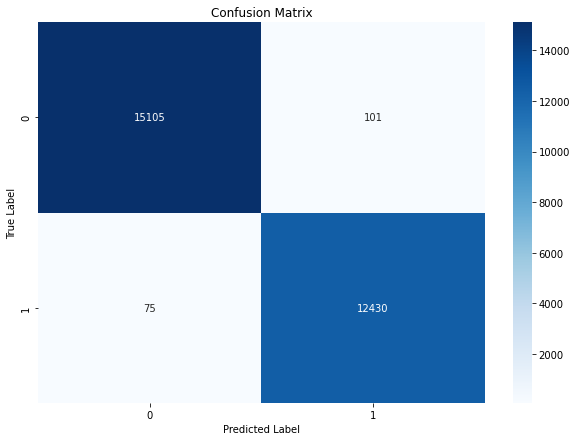

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions from the model
model.eval()
y_pred = []
with torch.no_grad():
    for i in range(0, len(X_test_tensor), 64):  # Using the same batch size
        batch_X = X_test_tensor[i:i + 64]
        outputs = model(batch_X)
        y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# Convert predictions and true labels to numpy arrays
y_pred = np.array(y_pred)
y_test_np = y_test_tensor.cpu().numpy()

# Create confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Display the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotting Confusion Matrix for the last model

In [15]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# # Get predictions from the model
# model.eval()
# y_pred = []
# with torch.no_grad():
#     for i in range(0, len(X_test_tensor), 64):  # Using the same batch size
#         batch_X = X_test_tensor[i:i + 64]
#         outputs = model(batch_X)
#         y_pred.extend(outputs.argmax(dim=1).cpu().numpy())

# # Convert predictions and true labels to numpy arrays
# y_pred = np.array(y_pred)
# y_test_np = y_test_tensor.cpu().numpy()

# # Create confusion matrix
# cm = confusion_matrix(y_test_np, y_pred)

# # Display the confusion matrix
# plt.figure(figsize=(10, 7))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Confusion Matrix')
# plt.show()

# Building 4L5F KAN Model with best split index and best accuracy

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

def evaluate_model_with_split(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Convert to tensors
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

        # Train the model
        train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, num_epochs=100)

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            outputs = model(X_test_tensor)
            predictions = outputs.argmax(dim=1)
            accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predictions.cpu().numpy())
            accuracies.append(accuracy)

    return accuracies

# Initialize your model
layers_hidden = [X_train_tensor.shape[1], 128, 64, 32, 16, len(label_encoder.classes_)]
model = KAN(layers_hidden, grid_size=3, spline_order=3).to(device)

# Evaluate with different splits
accuracies = evaluate_model_with_split(model, X_preprocessed, y_encoded, n_splits=5)

# Reporting the best accuracy and its index
best_accuracy = max(accuracies)
best_split_index = accuracies.index(best_accuracy)
print(f"Best Split Index: {best_split_index}, Best Accuracy: {best_accuracy:.4f}")

Epoch [1/100], Train Loss: 0.0006, Train Acc: 0.9902, Val Loss: 0.0797, Val Acc: 0.5470
Epoch [2/100], Train Loss: 0.0013, Train Acc: 0.9802, Val Loss: 0.0622, Val Acc: 0.5470
Epoch [3/100], Train Loss: 0.0010, Train Acc: 0.9822, Val Loss: 0.0333, Val Acc: 0.5470
Epoch [4/100], Train Loss: 0.0007, Train Acc: 0.9881, Val Loss: 0.0216, Val Acc: 0.5590
Epoch [5/100], Train Loss: 0.0010, Train Acc: 0.9830, Val Loss: 0.1223, Val Acc: 0.5470
Epoch [6/100], Train Loss: 0.0016, Train Acc: 0.9796, Val Loss: 0.0269, Val Acc: 0.5623
Epoch [7/100], Train Loss: 0.0008, Train Acc: 0.9813, Val Loss: 0.0625, Val Acc: 0.5470
Epoch [8/100], Train Loss: 0.0009, Train Acc: 0.9867, Val Loss: 0.0421, Val Acc: 0.5470
Epoch [9/100], Train Loss: 0.0008, Train Acc: 0.9837, Val Loss: 0.0501, Val Acc: 0.5470
Epoch [10/100], Train Loss: 0.0009, Train Acc: 0.9845, Val Loss: 0.0485, Val Acc: 0.5470
Epoch [11/100], Train Loss: 0.0010, Train Acc: 0.9837, Val Loss: 0.0442, Val Acc: 0.5474
Epoch [12/100], Train Loss: 0.

# Plot for Best Split index and accuracy

In [ ]:
# Plotting accuracies for each split
plt.figure(figsize=(10, 5))
plt.plot(range(5), accuracies, marker='o')
plt.title('Accuracy for Each Split')
plt.xlabel('Split Index')
plt.ylabel('Accuracy')
plt.xticks(range(5))
plt.grid()
plt.show()

# Evaluationg again for selected ratios with 4L5F KAN  50:25:25 is highest in both the Runs
# Run1

/home/sharmila/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 0.0015, Train Acc: 0.9701, Val Loss: 0.0006, Val Acc: 0.9890
Epoch [2/100], Train Loss: 0.0005, Train Acc: 0.9894, Val Loss: 0.0005, Val Acc: 0.9909
Epoch [3/100], Train Loss: 0.0004, Train Acc: 0.9926, Val Loss: 0.0004, Val Acc: 0.9924
Epoch [4/100], Train Loss: 0.0003, Train Acc: 0.9940, Val Loss: 0.0004, Val Acc: 0.9930
Epoch [5/100], Train Loss: 0.0003, Train Acc: 0.9948, Val Loss: 0.0004, Val Acc: 0.9922
Epoch [6/100], Train Loss: 0.0003, Train Acc: 0.9953, Val Loss: 0.0004, Val Acc: 0.9944
Epoch [7/100], Train Loss: 0.0002, Train Acc: 0.9959, Val Loss: 0.0003, Val Acc: 0.9948
Epoch [8/100], Train Loss: 0.0002, Train Acc: 0.9963, Val Loss: 0.0004, Val Acc: 0.9936
Epoch [9/100], Train Loss: 0.0002, Train Acc: 0.9965, Val Loss: 0.0004, Val Acc: 0.9940
Epoch [10/100], Train Loss: 0.0002, Train Acc: 0.9967, Val Loss: 0.0004, Val Acc: 0.9946
Epoch [11/100], Train Loss: 0.0002, Train Acc: 0.9966, Val Loss: 0.0004, Val Acc: 0.9940
Epoch [12/100], Train Loss: 0.

/home/sharmila/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 0.0001, Train Acc: 0.9975, Val Loss: 0.0003, Val Acc: 0.9959
Epoch [2/100], Train Loss: 0.0001, Train Acc: 0.9980, Val Loss: 0.0004, Val Acc: 0.9960
Epoch [3/100], Train Loss: 0.0001, Train Acc: 0.9981, Val Loss: 0.0004, Val Acc: 0.9960
Epoch [4/100], Train Loss: 0.0001, Train Acc: 0.9979, Val Loss: 0.0004, Val Acc: 0.9955
Epoch [5/100], Train Loss: 0.0001, Train Acc: 0.9980, Val Loss: 0.0004, Val Acc: 0.9960
Epoch [6/100], Train Loss: 0.0001, Train Acc: 0.9983, Val Loss: 0.0004, Val Acc: 0.9961
Epoch [7/100], Train Loss: 0.0001, Train Acc: 0.9982, Val Loss: 0.0004, Val Acc: 0.9955
Epoch [8/100], Train Loss: 0.0001, Train Acc: 0.9982, Val Loss: 0.0004, Val Acc: 0.9954
Epoch [9/100], Train Loss: 0.0001, Train Acc: 0.9984, Val Loss: 0.0004, Val Acc: 0.9945
Epoch [10/100], Train Loss: 0.0001, Train Acc: 0.9988, Val Loss: 0.0005, Val Acc: 0.9956
Early stopping on epoch 11
Train Ratio: 0.6, Validation Ratio: 0.2, Test Accuracy: 0.9955


/home/sharmila/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 0.0001, Train Acc: 0.9985, Val Loss: 0.0004, Val Acc: 0.9952
Epoch [2/100], Train Loss: 0.0001, Train Acc: 0.9983, Val Loss: 0.0004, Val Acc: 0.9960
Epoch [3/100], Train Loss: 0.0001, Train Acc: 0.9986, Val Loss: 0.0005, Val Acc: 0.9955
Epoch [4/100], Train Loss: 0.0001, Train Acc: 0.9986, Val Loss: 0.0005, Val Acc: 0.9952
Epoch [5/100], Train Loss: 0.0001, Train Acc: 0.9990, Val Loss: 0.0004, Val Acc: 0.9958
Epoch [6/100], Train Loss: 0.0001, Train Acc: 0.9986, Val Loss: 0.0005, Val Acc: 0.9948
Epoch [7/100], Train Loss: 0.0001, Train Acc: 0.9986, Val Loss: 0.0005, Val Acc: 0.9947
Epoch [8/100], Train Loss: 0.0000, Train Acc: 0.9990, Val Loss: 0.0005, Val Acc: 0.9953
Epoch [9/100], Train Loss: 0.0000, Train Acc: 0.9993, Val Loss: 0.0005, Val Acc: 0.9960
Epoch [10/100], Train Loss: 0.0000, Train Acc: 0.9992, Val Loss: 0.0005, Val Acc: 0.9961
Early stopping on epoch 11
Train Ratio: 0.5, Validation Ratio: 0.25, Test Accuracy: 0.9968


/home/sharmila/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 0.0002, Train Acc: 0.9978, Val Loss: 0.0004, Val Acc: 0.9946
Epoch [2/100], Train Loss: 0.0001, Train Acc: 0.9983, Val Loss: 0.0004, Val Acc: 0.9952
Epoch [3/100], Train Loss: 0.0001, Train Acc: 0.9982, Val Loss: 0.0004, Val Acc: 0.9956
Epoch [4/100], Train Loss: 0.0001, Train Acc: 0.9985, Val Loss: 0.0004, Val Acc: 0.9940
Epoch [5/100], Train Loss: 0.0001, Train Acc: 0.9985, Val Loss: 0.0004, Val Acc: 0.9946
Epoch [6/100], Train Loss: 0.0001, Train Acc: 0.9986, Val Loss: 0.0004, Val Acc: 0.9952
Epoch [7/100], Train Loss: 0.0001, Train Acc: 0.9986, Val Loss: 0.0005, Val Acc: 0.9938
Epoch [8/100], Train Loss: 0.0001, Train Acc: 0.9986, Val Loss: 0.0005, Val Acc: 0.9954
Epoch [9/100], Train Loss: 0.0001, Train Acc: 0.9987, Val Loss: 0.0004, Val Acc: 0.9959
Epoch [10/100], Train Loss: 0.0001, Train Acc: 0.9986, Val Loss: 0.0004, Val Acc: 0.9947
Epoch [11/100], Train Loss: 0.0001, Train Acc: 0.9989, Val Loss: 0.0005, Val Acc: 0.9947
Early stopping on epoch 12
Tra

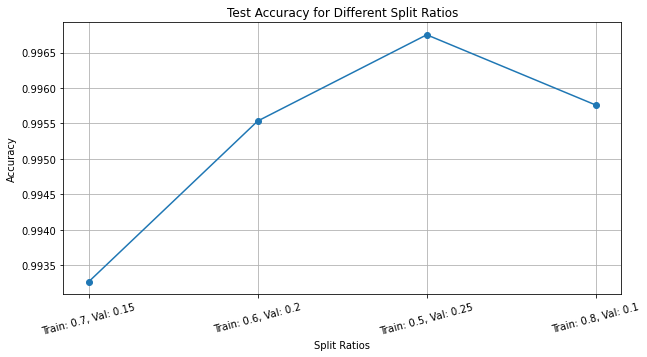

Best Split Ratio: Train: 0.5, Validation: 0.25, Accuracy: 0.9968


In [8]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_model(model, X, y, train_size, val_size, num_epochs=100):
    # Split the data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size/(1 - train_size), stratify=y_temp, random_state=42)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

    # Train the model
    train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=num_epochs)

    # Evaluate on the test set
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        predictions = outputs.argmax(dim=1)
        accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predictions.cpu().numpy())
    return accuracy

# Define your model architecture
layers_hidden = [X.shape[1], 128, 64, 32, 16, len(label_encoder.classes_)]
model = KAN(layers_hidden, grid_size=3, spline_order=3).to(device)

# Define split ratios to evaluate
ratios = [(0.7, 0.15), (0.6, 0.2), (0.50, 0.25), (0.8, 0.1)]
accuracies = []

# Evaluate each split ratio
for train_ratio, val_ratio in ratios:
    accuracy = evaluate_model(model, X_preprocessed, y_encoded, train_size=train_ratio, val_size=val_ratio)
    accuracies.append(accuracy)
    print(f"Train Ratio: {train_ratio}, Validation Ratio: {val_ratio}, Test Accuracy: {accuracy:.4f}")

# Plotting the accuracies for different ratios
plt.figure(figsize=(10, 5))
plt.plot([f'Train: {r[0]}, Val: {r[1]}' for r in ratios], accuracies, marker='o')
plt.title('Test Accuracy for Different Split Ratios')
plt.xlabel('Split Ratios')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid()
plt.show()

# Finding the best split ratio
best_accuracy = max(accuracies)
best_ratio_index = accuracies.index(best_accuracy)
best_train_ratio = ratios[best_ratio_index][0]
best_val_ratio = ratios[best_ratio_index][1]
print(f"Best Split Ratio: Train: {best_train_ratio}, Validation: {best_val_ratio}, Accuracy: {best_accuracy:.4f}")

# Run2

In [ ]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def evaluate_model(model, X, y, train_size, val_size, num_epochs=100):
    # Split the data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=train_size, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size/(1 - train_size), stratify=y_temp, random_state=42)

    # Convert to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

    # Train the model
    train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, num_epochs=num_epochs)

    # Evaluate on the test set
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        predictions = outputs.argmax(dim=1)
        accuracy = accuracy_score(y_test_tensor.cpu().numpy(), predictions.cpu().numpy())
    return accuracy

# Define your model architecture
layers_hidden = [X.shape[1], 128, 64, 32, 16, len(label_encoder.classes_)]
model = KAN(layers_hidden, grid_size=3, spline_order=3).to(device)

# Define split ratios to evaluate
ratios = [(0.8, 0.1), (0.7, 0.15), (0.6, 0.2), (0.50, 0.25) ]
accuracies = []

# Evaluate each split ratio
for train_ratio, val_ratio in ratios:
    accuracy = evaluate_model(model, X_preprocessed, y_encoded, train_size=train_ratio, val_size=val_ratio)
    accuracies.append(accuracy)
    print(f"Train Ratio: {train_ratio}, Validation Ratio: {val_ratio}, Test Accuracy: {accuracy:.4f}")

# Plotting the accuracies for different ratios
plt.figure(figsize=(10, 5))
plt.plot([f'Train: {r[0]}, Val: {r[1]}' for r in ratios], accuracies, marker='o')
plt.title('Test Accuracy for Different Split Ratios')
plt.xlabel('Split Ratios')
plt.ylabel('Accuracy')
plt.xticks(rotation=15)
plt.grid()
plt.show()

# Finding the best split ratio
best_accuracy = max(accuracies)
best_ratio_index = accuracies.index(best_accuracy)
best_train_ratio = ratios[best_ratio_index][0]
best_val_ratio = ratios[best_ratio_index][1]
print(f"Best Split Ratio: Train: {best_train_ratio}, Validation: {best_val_ratio}, Accuracy: {best_accuracy:.4f}")

# End